# Air Traffic Control

In this example we'll visualize air traffic control data for planes that arrive at or depart from three New York City-area airports: [JFK](https://en.wikipedia.org/wiki/John_F._Kennedy_International_Airport), [LGA](https://en.wikipedia.org/wiki/LaGuardia_Airport), and [EWR](https://en.wikipedia.org/wiki/Newark_Liberty_International_Airport).

This air traffic control data comes from [adsb.lol](https://adsb.lol/), an open source project to distribute [ADSB](https://en.wikipedia.org/wiki/Automatic_Dependent_Surveillance%E2%80%93Broadcast) data.

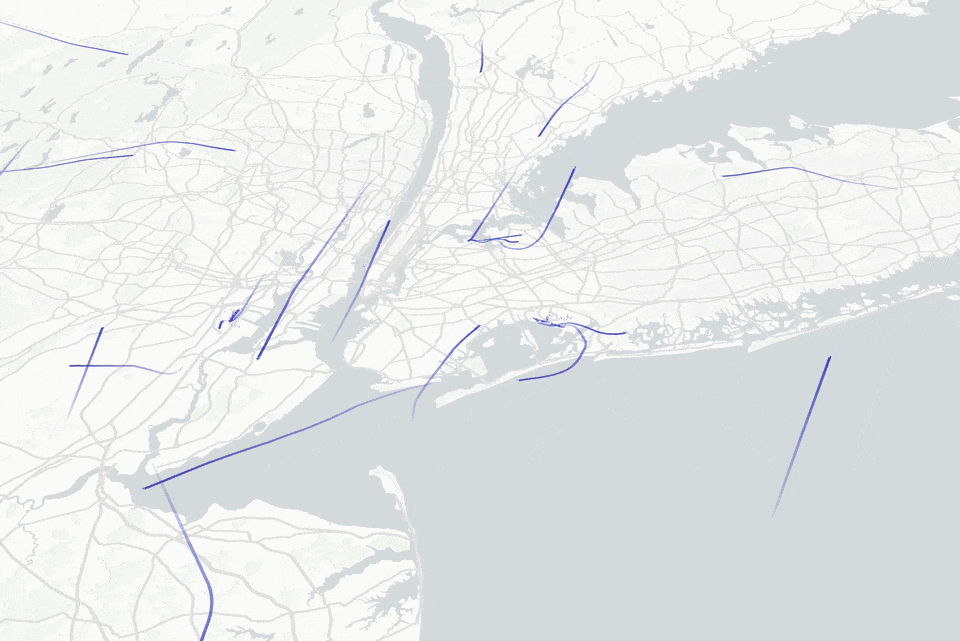

## Dependencies

```
pip install lonboard requests
```

## Imports


In [ ]:
from datetime import timedelta
from io import BytesIO

import requests
from arro3.io import read_parquet

from lonboard import Map
from lonboard.experimental import TripsLayer

The bulk ADSB files [distributed by adsb.lol](https://github.com/adsblol/globe_history_2024) are very large (~2GB). To make it easy to use this data in a demo, we've prepared an extract of only the data used in this demo.

Information about how this extract was prepared is [documented in `kylebarron/adsb-extract`](https://github.com/kylebarron/adsb-extract).

The Parquet file we're loading has been constructed in the specific format required by the `TripsLayer`. Airplane trajectories are stored as GeoArrow LineStrings in the `geometry` column. Timestamps are stored in the `timestamp` column in an Arrow list array, with the same nesting as the `geometry` column, so there's one timestamp per point.


In [ ]:
# Fetch the Parquet file and parse to an Arrow table
url = "https://github.com/kylebarron/adsb-extract/releases/download/v0.1/2024-10-03_traces.parquet"
r = requests.get(url)
table = read_parquet(BytesIO(r.content)).read_all()

Now we can create a `TripsLayer`. Since we already have Arrow data, we can pass it directly into the `table` argument.


In [ ]:
layer = TripsLayer(
    table=table,
    get_timestamps=table["timestamp"],
    width_min_pixels=2,
    get_color=[30, 30, 200, 200],
    trail_length=200,
    # Turn off tooltip data selection for better performance
    pickable=False,
)

In [ ]:
m = Map(
    layer,
    view_state={
        "longitude": -73.8,
        "latitude": 40.6,
        "zoom": 9.5,
        "pitch": 50.6,
        "bearing": 8.24,
    },
    # Increase height of generated map (API subject to change)
    _height=800,
)
m

Now we can animate the layer! Click the play button to watch the data animate!


In [ ]:
layer.animate(step=timedelta(minutes=1), fps=50)

If you wish, you can stop the animation either with the UI controls above or with `stop_animation` below:


In [ ]:
layer.stop_animation()

## Notes

- This dataset contains one day of flight data in the UTC time zone. So around 6 AM UTC time the animation will be mostly empty because not many planes are taking off after midnight eastern time.
- If you see some planes moving _very fast_ between Asia and the U.S. west coast, that's due to issues in data handling around the antimeridian. When creating these data extracts in [`adsb-extract`](https://github.com/kylebarron/adsb-extract), I didn't do any special antimeridian handling, and so by default deck.gl thinks data is moving on a euclidean plane. The ideal way to solve this is to split trajectories that cross the antimeridian into two segments, but this is not yet implemented.
